# Convective adjustment

This notebook explains how the [convective adjustment algorithm](https://github.com/jduffield65/ClimateModel/blob/9e8647232af8a5fad1faecd0b946cb0dac9c68d1/Model/radiation/convective_adjustment.py) works.

Lets denote the critical lapse rate by $\gamma$ in units of $K/m$. Then convective motions develop where the temperature gradient becomes supercritical: $\frac{\partial T}{\partial z} < -\gamma$ where $\gamma > 0$. These convective motions establish a new gradient $\frac{\partial T}{\partial z} = -\gamma$, and the adjustment occurs adiabatically. 

If we sub the equation for enthalpy $h = u + pv$ into the first law: $du = dq - pdv$, we get $dh = dq + vdp$. If the process occurs adiabatically, $dq = 0$, and in our simulations, the pressure profile remains constant so $dp = 0$, hence we require $dh = 0$ for the convective adjustment.

For a single column, $H = \int_0^{\infty}{\rho h dz}$ where $h = c_pT$ is the enthalpy per unit mass ($c_p$ is the heat capacity of air at constant pressure per unit mass, units are J/K/kg) and $\rho$ is the mass per unit length. Using the hydrostatic relation:

\begin{equation}
\frac{\partial p}{\partial z} = -\rho g
\label{eq: 1}\tag{1}
\end{equation}

we can write this as $H = \frac{c_p}{g}\int_0^{p_{surface}}{T dp}$. Thus during the convective adjustment process, for the process to be adiabatic we require $H$ and thus $\int_0^{p_{surface}}{T dp}$ to remian constant.

So the basic requirement of convective adjustment is to eliminate regions where:

\begin{equation}
\frac{\partial T}{\partial z} < -\gamma
\label{eq: 2}\tag{2}
\end{equation}

by replacing the gradient with:

\begin{equation}
\frac{\partial T}{\partial z} = -\gamma
\label{eq: 3}\tag{3}
\end{equation}

such that:

\begin{equation}
\int_0^{p_{surface}}{T dp} = constant
\label{eq: 4}\tag{4}
\end{equation}


## Eliminating altitude dependence

We now want to find expressions for $(2)$ and $(3)$ in terms of pressure rather than altitude as this is a more convenient variable.

Let us first write temperature in terms of a potential temperature like variable $\theta$:

\begin{equation}
T = \theta \left(\frac{p}{p_0}\right)^{\alpha}
\label{eq: 5}\tag{5}
\end{equation}

where $p_0$ is a reference pressure, [taken to be the surface pressure in this algorithm](https://github.com/jduffield65/ClimateModel/blob/9e8647232af8a5fad1faecd0b946cb0dac9c68d1/Model/radiation/convective_adjustment.py#L41) and the power $\alpha$ is as yet undetermined. From this, we have:

\begin{equation}
\frac{\partial T}{\partial z} = \left(\frac{p}{p_0}\right)^{\alpha} \left[\frac{\partial \theta}{\partial z} + \frac{\alpha \theta}{p} \frac{\partial p}{\partial z} \right]
\label{eq: 6}\tag{6}
\end{equation}

Then using $(1)$ and the equation of state $p = \rho R T$, we can eliminate $z$, $T$ and $\rho$ from this:

\begin{equation}
\frac{\partial T}{\partial z} = -\frac{pg}{R}\left[\frac{1}{\theta}\frac{\partial \theta}{\partial p} + \frac{\alpha}{p}\right]
\label{eq: 7}\tag{7}
\end{equation}

The only way that $(7)$ can be consistent with $(3)$ is if $\frac{\partial \theta}{\partial z} = 0$ and [$\alpha = \frac{R\gamma}{g}$](https://github.com/jduffield65/ClimateModel/blob/9e8647232af8a5fad1faecd0b946cb0dac9c68d1/Model/radiation/convective_adjustment.py#L42). So now $(2)$ and $(3)$ become:

\begin{equation}
\frac{\partial \theta}{\partial p} > 0
\label{eq: 8}\tag{8}
\end{equation}

\begin{equation}
\theta = constant
\label{eq: 9}\tag{9}
\end{equation}

## Thermosphere example

I will now illustrate how the code implements equations $(4)$, $(8)$ and $(9)$ using the thermosphere example from [```grey_radiation.ipynb```](https://github.com/jduffield65/ClimateModel/blob/9e8647232af8a5fad1faecd0b946cb0dac9c68d1/grey_radiation.ipynb). 

The below two cells just evolve the thermosphere example to equilibrium (in the absence of convection) and then find the connected regions that are convectively unstable (shown in red in the $T$ and $\theta$ plots) using [code copied](https://github.com/jduffield65/ClimateModel/blob/9e8647232af8a5fad1faecd0b946cb0dac9c68d1/Model/radiation/convective_adjustment.py#L41-L54) from ```convective_adjustment.py```. You can see that these unstable regions are the only regions that satisfy $(8)$.

In [1]:
# Use thermosphere example to illustrate convective adjustment
from Model.radiation.convective_adjustment import *;
from Model.radiation.grey import OpticalDepthFunctions;
import numpy as np
import matplotlib.pyplot as plt
from Model.radiation.grey import GreyGas;

thermosphere = GreyGas(nz='auto', ny=1, tau_lw_func=OpticalDepthFunctions.scale_height_and_peak_in_atmosphere,
                       tau_lw_func_args=[51000, 4, 100, 600, 0.1], tau_sw_func=OpticalDepthFunctions.scale_height_and_peak_in_atmosphere,
                       tau_sw_func_args=[p_surface, 0.12, 100, 20, 0.002]);
_ = thermosphere.evolve_to_equilibrium(flux_thresh=0.1);
p = thermosphere.p[:, 0];
T = thermosphere.T[:, 0];

/Users/joshduffield/Documents/ObjectOrientatedPython/PyCharmTest/venv/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):
/Users/joshduffield/Documents/PlanetaryClimate/ClimateModel/Model/radiation/grey.py:914: RuntimeWarning: divide by zero encountered in log
  return -1 / np.log(p_fall_value / p_surface)


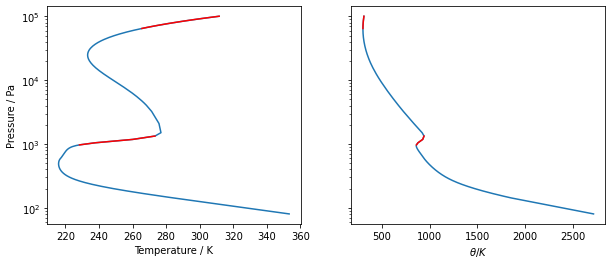

In [2]:
lapserate = g/c_p_dry  # dry adiabatic lapse rate
p_reference = p_surface
alpha = R_specific * lapserate / g
theta = get_theta(T, p, p_reference, alpha)
theta_initial = theta.copy()
theta_diff = np.ediff1d(theta)
theta_diff = np.concatenate((theta_diff, [theta_diff[-1]]))
small = 1e-10  # so don't worry about extreme small theta_diff
unstable_levels = np.where(theta_diff < -small)[0] # negative as pressure is decreasing.
unstable_groups = []
for k, j in groupby(enumerate(unstable_levels), lambda x: x[0] - x[1]):
    group = (map(itemgetter(1), j))
    group = list(map(int, group))
    unstable_groups.append(group)
    
def T_theta_plot_set_up():
    fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,4))
    #axs[0].invert_yaxis()
    axs[0].set_yscale('log')
    axs[0].set_ylabel('Pressure / Pa');
    axs[0].set_xlabel('Temperature / K');
    axs[1].set_xlabel(r'$\theta / K$');
    return axs
axs = T_theta_plot_set_up()
axs[0].plot(T, p);
axs[1].plot(theta_initial, p);
for unstable_group in unstable_groups:
    axs[0].plot(T[unstable_group], p[unstable_group], color='r');
    axs[1].plot(theta_initial[unstable_group], p[unstable_group], color='r');

The [next cell](https://github.com/jduffield65/ClimateModel/blob/9e8647232af8a5fad1faecd0b946cb0dac9c68d1/Model/radiation/convective_adjustment.py#L56-L83) deals with each unstable group in turn. For each, it then finds $\theta_{low}$, which is $\theta$ at the lowest pressure level of the group and sets $\theta = \theta_{low}$ for the whole unstable region as one way to satisfy $(9)$. It then computes the resultant temperature profile: ```adjust_theta['lower']['T']``` and total enthalpy: ```adjust_theta['lower']['enthalpy']```.

This process is then repeated but this time setting $\theta = \theta_{upper}$ for the whole unstable region as another way to satisfy $(9)$, where $\theta_{upper}$ is $\theta$ at the highest pressure level of the group. This produces ```adjust_theta['upper']['T']``` and ```adjust_theta['upper']['enthalpy']```.

In [3]:
def get_adjust_theta(unstable_group):
    adjust_theta = {'lower': {}, 'upper': {}}
    # lower pressure level of unstable region
    min_pressure_to_change = unstable_group[-1]+1
    adjust_theta['lower']['theta'] = theta[min_pressure_to_change]
    low_theta_levels = np.where(theta < adjust_theta['lower']['theta'])[0]
    low_theta_levels = low_theta_levels[low_theta_levels < min_pressure_to_change]
    if len(low_theta_levels) == 0:
        max_pressure_to_change = 0
    else:
        max_pressure_to_change = nearest_value_in_array(low_theta_levels, min_pressure_to_change) + 1
    adjust_theta['lower']['change_levels'] = np.arange(max_pressure_to_change, min_pressure_to_change+1)
    # upper pressure level of unstable region
    max_pressure_to_change = unstable_group[0]
    adjust_theta['upper']['theta'] = theta[max_pressure_to_change]
    high_theta_levels = np.where(theta > adjust_theta['upper']['theta'])[0]
    high_theta_levels = high_theta_levels[high_theta_levels > max_pressure_to_change]
    if len(high_theta_levels) == 0:
        min_pressure_to_change = len(p) - 1
    else:
        min_pressure_to_change = nearest_value_in_array(high_theta_levels, max_pressure_to_change)
    adjust_theta['upper']['change_levels'] = np.arange(max_pressure_to_change, min_pressure_to_change + 1)

    for key in adjust_theta:
        theta_adjust = theta.copy()
        theta_adjust[adjust_theta[key]['change_levels']] = adjust_theta[key]['theta']
        adjust_theta[key]['theta_new'] = theta_adjust
        adjust_theta[key]['T'] = get_T(theta_adjust, p, p_reference, alpha)
        adjust_theta[key]['enthalpy'] = get_enthalpy(adjust_theta[key]['T'], p)
    return adjust_theta

adjust_theta = get_adjust_theta(unstable_groups[1])

The temperature and $\theta$ profiles obtained from $\theta_{low}$ and $\theta_{upper}$ are shown below for the lowest pressure unstable region. You can clearly see that both these profiles now satisfy $(8)$ for all pressure levels so which one to choose?

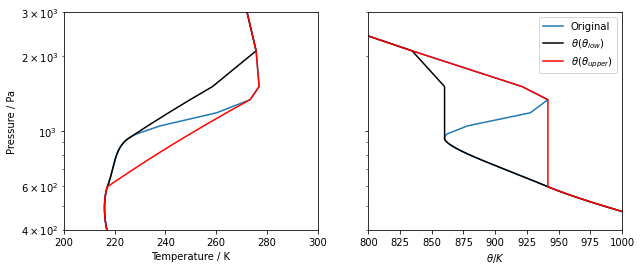

In [4]:
def theta_low_up_plot():
    axs = T_theta_plot_set_up()
    axs[0].plot(T, p);
    axs[0].plot(adjust_theta['lower']['T'], p, color='k');
    axs[0].plot(adjust_theta['upper']['T'], p, color='r');
    axs[1].plot(theta_initial, p, label='Original');
    axs[1].plot(adjust_theta['lower']['theta_new'], p, color='k', label=r'$\theta(\theta_{low})$');
    axs[1].plot(adjust_theta['upper']['theta_new'], p, color='r', label=r'$\theta(\theta_{upper})$');
    axs[0].set_ylim([4e2,3e3]);
    axs[0].set_xlim([200,300]);
    axs[1].set_xlim([800,1000]);
    return axs
axs = theta_low_up_plot()
axs[1].legend();

Well as the next cell shows, neither of these profiles satisfies $(4)$:

In [5]:
enthalpy = get_enthalpy(T, p);
print('Initial Enthalpy:\t' + str(enthalpy))
print('theta_low Enthalpy:\t' + str(adjust_theta['lower']['enthalpy']))
print('theta_upper Enthalpy:\t' + str(adjust_theta['upper']['enthalpy']))

Initial Enthalpy:	26335845.277027592
theta_low Enthalpy:	26321701.63144755
theta_upper Enthalpy:	26343981.16320732


So we need to combine the two temperature profiles in such a manner that enthalpy remains the same. [We can do this through](https://github.com/jduffield65/ClimateModel/blob/9e8647232af8a5fad1faecd0b946cb0dac9c68d1/Model/radiation/convective_adjustment.py#L85-L88):

\begin{equation}
T_{final} = (1-\beta)T(\theta_{low}) + \beta T(\theta_{upper})
\label{eq: 10}\tag{10}
\end{equation}

such that:

\begin{equation}
\beta = \frac{H - H(\theta_{low})}{H(\theta_{upper}) - H(\theta_{low})}
\label{eq: 11}\tag{11}
\end{equation}

as the next cell shows.

Initial Enthalpy: 	26335845.277027592
Final Enthalpy: 	26335845.277027592


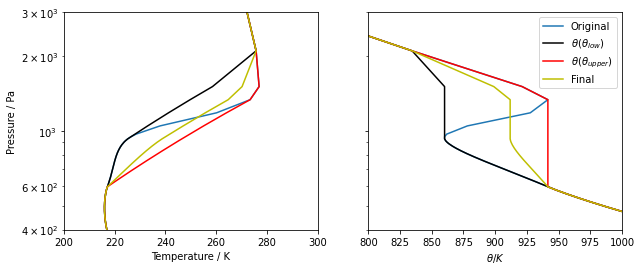

In [6]:
def get_new_T(adjust_theta):
    beta = (enthalpy - adjust_theta['lower']['enthalpy']) / (
            adjust_theta['upper']['enthalpy'] - adjust_theta['lower']['enthalpy']);
    T_adjusted = beta * adjust_theta['upper']['T'] + (1-beta) * adjust_theta['lower']['T'];
    return T_adjusted
T_adjusted = get_new_T(adjust_theta)
adjusted_enthalpy = get_enthalpy(T_adjusted, p);
print('Initial Enthalpy: \t' + str(enthalpy))
print('Final Enthalpy: \t' + str(adjusted_enthalpy))

axs = theta_low_up_plot()
axs[0].plot(T_adjusted, p, color='y');
axs[1].plot(get_theta(T_adjusted, p, p_reference, alpha), p, color='y', label='Final');
axs[1].legend();
plt.show()

## Final profile
We then repeat this process with all other unstable groups using the adjusted temperature profile. This then removes all unstable pressure levels. We also see that the surface temperature has decreased as a result of the reduced temperature gradient near the surface.

In [7]:
for unstable_group in unstable_groups:
    adjust_theta = get_adjust_theta(unstable_group)
    T_final = get_new_T(adjust_theta)
    theta = get_theta(T_final, p, p_reference, alpha)
theta_diff = np.ediff1d(theta)
theta_diff = np.concatenate((theta_diff, [theta_diff[-1]]))
unstable_levels = np.where(theta_diff < -small)[0]
print('Final number of unstable pressure levels: ' + str(len(unstable_levels)))

Final number of unstable pressure levels: 0


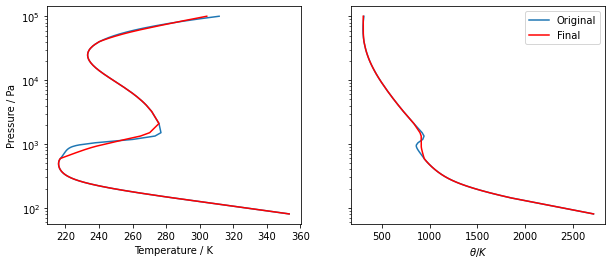

In [8]:
axs = T_theta_plot_set_up()
axs[0].plot(T, p);
axs[0].plot(T_final, p, color='r');
axs[1].plot(theta_initial, p, label='Original');
axs[1].plot(theta, p, color='r', label='Final');
axs[1].legend();